In [1]:
try:
    from ultralytics import YOLO
except ImportError:
    !pip install ultralytics
    import os
    os.kill(os.getpid(), 9)

import kagglehub
from google.colab import drive
import cv2
import os
import glob
import numpy as np
from tqdm import tqdm
import multiprocessing

import yaml

from IPython.display import display, Image
from google.colab.patches import cv2_imshow
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
drive.mount('/content/drive/',)

Mounted at /content/drive/


In [3]:
# !cd /content
HOME = os.getcwd()
print(HOME)

/content


In [4]:
# Download latest version
path = kagglehub.dataset_download("roscoekerby/firesmoke-detection-yolo-v9")

print("Path to dataset files:", path)

100%|██████████| 924M/924M [00:41<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/roscoekerby/firesmoke-detection-yolo-v9/versions/2


In [5]:
!mv "/root/.cache/kagglehub/datasets/roscoekerby/firesmoke-detection-yolo-v9/versions/2/Fire and Smoke Dataset" "/content"

In [6]:
!apt-get install -qq tree
!tree -d /content/"Fire and Smoke Dataset"

Selecting previously unselected package tree.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/content/Fire and Smoke Dataset
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

9 directories


In [7]:
# โหลดไฟล์ YAML เก่า
with open('/content/Fire and Smoke Dataset/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

# แก้ไขค่าในไฟล์ YAML
data['test'] = '/content/Fire and Smoke Dataset/test/images'
data['train'] = '/content/Fire and Smoke Dataset/train/images'
data['val'] = '/content/Fire and Smoke Dataset/valid/images'

# บันทึกไฟล์ YAML ใหม่
with open('/content/Fire and Smoke Dataset/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, allow_unicode=True)

print("ไฟล์ YAML ถูกอัปเดตแล้ว")

ไฟล์ YAML ถูกอัปเดตแล้ว


**เพิ่มขนาดรูปและ optimizer**

In [ ]:
%cd {HOME}
!rm -rf runs/  # ล้างผลลัพธ์เก่า

# ล้างแคชระบบ
!sudo sync && echo 3 | sudo tee /proc/sys/vm/drop_caches

# เทรนด้วยการตั้งค่าพิเศษ
# !yolo task=detect mode=train \
# model=yolov8n.pt \
# data="/content/Fire and Smoke Dataset/data.yaml" \
# epochs=40 \
# imgsz=416 \
# batch=192 \
# workers=6 \
# cache='disk' \
# optimizer='Adam' \
# lr0=0.001 \
# patience=5 \
# half=True \
# amp=True \
# rect=True \
# cos_lr=True \

!yolo task=detect mode=train model=yolov8n.pt data="/content/Fire and Smoke Dataset/data.yaml" epochs=40 imgsz=352 batch=192 workers=6 cache='disk' optimizer='SGD' lr0=0.015 momentum=0.9 amp=True half=True rect=True cos_lr=True close_mosaic=10 patience=15

# model=yolov8n.pt
# data=data.yaml
# epochs=50
# imgsz=416
# batch=512
# workers=8
# cache='ram'
# amp=True
# optimizer='Adam'
# patience=10
# pretrained=True
# half=True

/content
tee: /proc/sys/vm/drop_caches: Read-only file system
3
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Fire and Smoke Dataset/data.yaml, epochs=40, time=None, patience=15, batch=192, imgsz=352, save=True, save_period=-1, cache=disk, device=None, workers=6, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

In [ ]:
# สร้างโฟลเดอร์ใน Drive
save_dir = "/content/drive/MyDrive/YOLONEWDATASET/yolo_models"
!mkdir -p "{save_dir}"

# คัดลอกไฟล์ best.pt และ last.pt
shutil.copy("/content/runs/detect/train/weights/best.pt", save_dir)
shutil.copy("/content/runs/detect/train/weights/last.pt", save_dir)

print(f"บันทึกไฟล์เรียบร้อยที่: {save_dir}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/train/weights/best.pt'

In [ ]:
# กำหนด path ต้นทางและปลายทาง
source_path = "/content/runs/detect"  # โฟลเดอร์ที่ต้องการคัดลอก
destination_path = "/content/drive/MyDrive/YOLONEWDATASET/yolo_train_data"  # ปลายทางใน Drive

# ลบโฟลเดอร์เก่าใน Drive (ถ้ามี)
shutil.rmtree(destination_path, ignore_errors=True)

# คัดลอกทั้งโฟลเดอร์ (รวมไฟล์ย่อย)
shutil.copytree(source_path, destination_path)

print(f"คัดลอกเสร็จสิ้น! ตรวจสอบได้ที่: {destination_path}")

In [ ]:
# โหลดไฟล์ YAML เพื่อกำหนด path ของ test set
def load_yaml(yaml_path):
    with open(yaml_path, "r") as file:
        data = yaml.safe_load(file)
    return data

yaml_config = load_yaml("/content/Fire and Smoke Dataset/data.yaml")  # เปลี่ยนเป็น path ของไฟล์ YAML
TEST_PATH = os.path.join(HOME, "test", "images") # ใช้ path จาก YAML

In [ ]:
# โหลดข้อมูลการเทรนจาก CSV
csv_files = {
    "model yolo8n": "/content/runs/detect/train/results.csv",
}

In [ ]:
def plot_learning_curve(csv_file, model_name):
    df = pd.read_csv(csv_file)
    plt.figure(figsize=(12, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Training Loss', marker='o')
    plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.legend()

    # Plot Accuracy Curve (ใช้ mAP50 เป็นตัวแทน Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='Validation mAP50', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('mAP50')
    plt.title(f'{model_name} - Accuracy (mAP50) Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

for model_name, file in csv_files.items():
    plot_learning_curve(file, model_name)

In [ ]:
# โหลดโมเดลและสร้าง Confusion Matrix
models = {
    "model yolo8n": YOLO("/content/runs/detect/train/weights/best.pt"),
}
class_labels = ['fire', 'smoke']

In [ ]:
# ฟังก์ชันในการอ่านภาพและการทำนาย
def process_predictions(image, model, label_path):
    # ทำนาย
    predictions = model.predict(image, verbose=False)
    # อ่าน label จริงจากไฟล์
    true_labels = read_labels(label_path)

    # ถ้าไม่มีการทำนาย ให้เติม pred_labels ด้วย 0 (หมายถึงไม่พบการตรวจจับ)
    if not predictions[0].boxes:
        pred_labels = [0] * len(true_labels)  # เติม 0 สำหรับทุก label ที่ไม่มีการทำนาย
    else:
        pred_labels = [int(label) for label in predictions[0].boxes.cls.tolist()]

    return true_labels, pred_labels

# ฟังก์ชันตรวจสอบขนาดของ y_true และ y_pred
def check_consistent_length(y_true, y_pred):
    if len(y_true) != len(y_pred):
        print(f"Warning: The number of ground truth labels ({len(y_true)}) does not match the number of predictions ({len(y_pred)})")
        # ตรวจสอบเพื่อให้แน่ใจว่า length ตรงกัน
        min_length = min(len(y_true), len(y_pred))
        y_true = y_true[:min_length]
        y_pred = y_pred[:min_length]
    return y_true, y_pred

# คำนวณ mAP (mean Average Precision)
def calculate_map(y_true, y_pred, class_count):
    # mAP คำนวณจากค่า precision ที่หลากหลาย thresholds
    ap = []
    for c in range(class_count):
        true_positive = sum([1 for t, p in zip(y_true, y_pred) if t == c and p == c])
        false_positive = sum([1 for t, p in zip(y_true, y_pred) if t != c and p == c])
        false_negative = sum([1 for t, p in zip(y_true, y_pred) if t == c and p != c])

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        # คำนวณ F1-Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        ap.append(f1)

    # คำนวณค่า mAP (mean average precision)
    map_value = np.mean(ap)
    return map_value

# ตรวจสอบข้อมูลอีกครั้งหลังจากเพิ่มการเติม pred_labels
for model_name, model in models.items():
    print(f'\nEvaluating model: {model_name}')
    y_true_labels = []
    y_pred_labels = []
    for i, image in tqdm(enumerate(test_images), total=len(test_images), desc=f"Processing {model_name}"):
        # อ่าน label จริงจากไฟล์
        true_labels, pred_labels = process_predictions(image, model, test_labels[i])
        y_true_labels.extend(true_labels)  # ground truth
        y_pred_labels.extend(pred_labels)  # prediction

    # ตรวจสอบความยาวของ y_true และ y_pred
    y_true_labels, y_pred_labels = check_consistent_length(y_true_labels, y_pred_labels)

    # คำนวณ Overall Accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # คำนวณ Precision, Recall, F1-Score
    precision = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)
    recall = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)
    f1 = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)

    # คำนวณ mAP (mean Average Precision)
    map_value = calculate_map(y_true_labels, y_pred_labels, class_count=2)  # เนื่องจากมี 2 class (fire, smoke)

    # คำนวณ Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # แสดงผลการคำนวณ
    print(f"Confusion Matrix for {model_name}:")
    print(cm)
    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'mAP: {map_value:.4f}')

    # Class Accuracy (สำหรับแต่ละคลาส)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f'Class Accuracy: {class_accuracy}')

    # Overall Accuracy
    overall_accuracy = cm.diagonal().sum() / cm.sum()
    print(f'Calculated Overall Accuracy: {overall_accuracy:.4f}')

    # แสดง Confusion Matrix ด้วย Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=config['names'], yticklabels=config['names'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

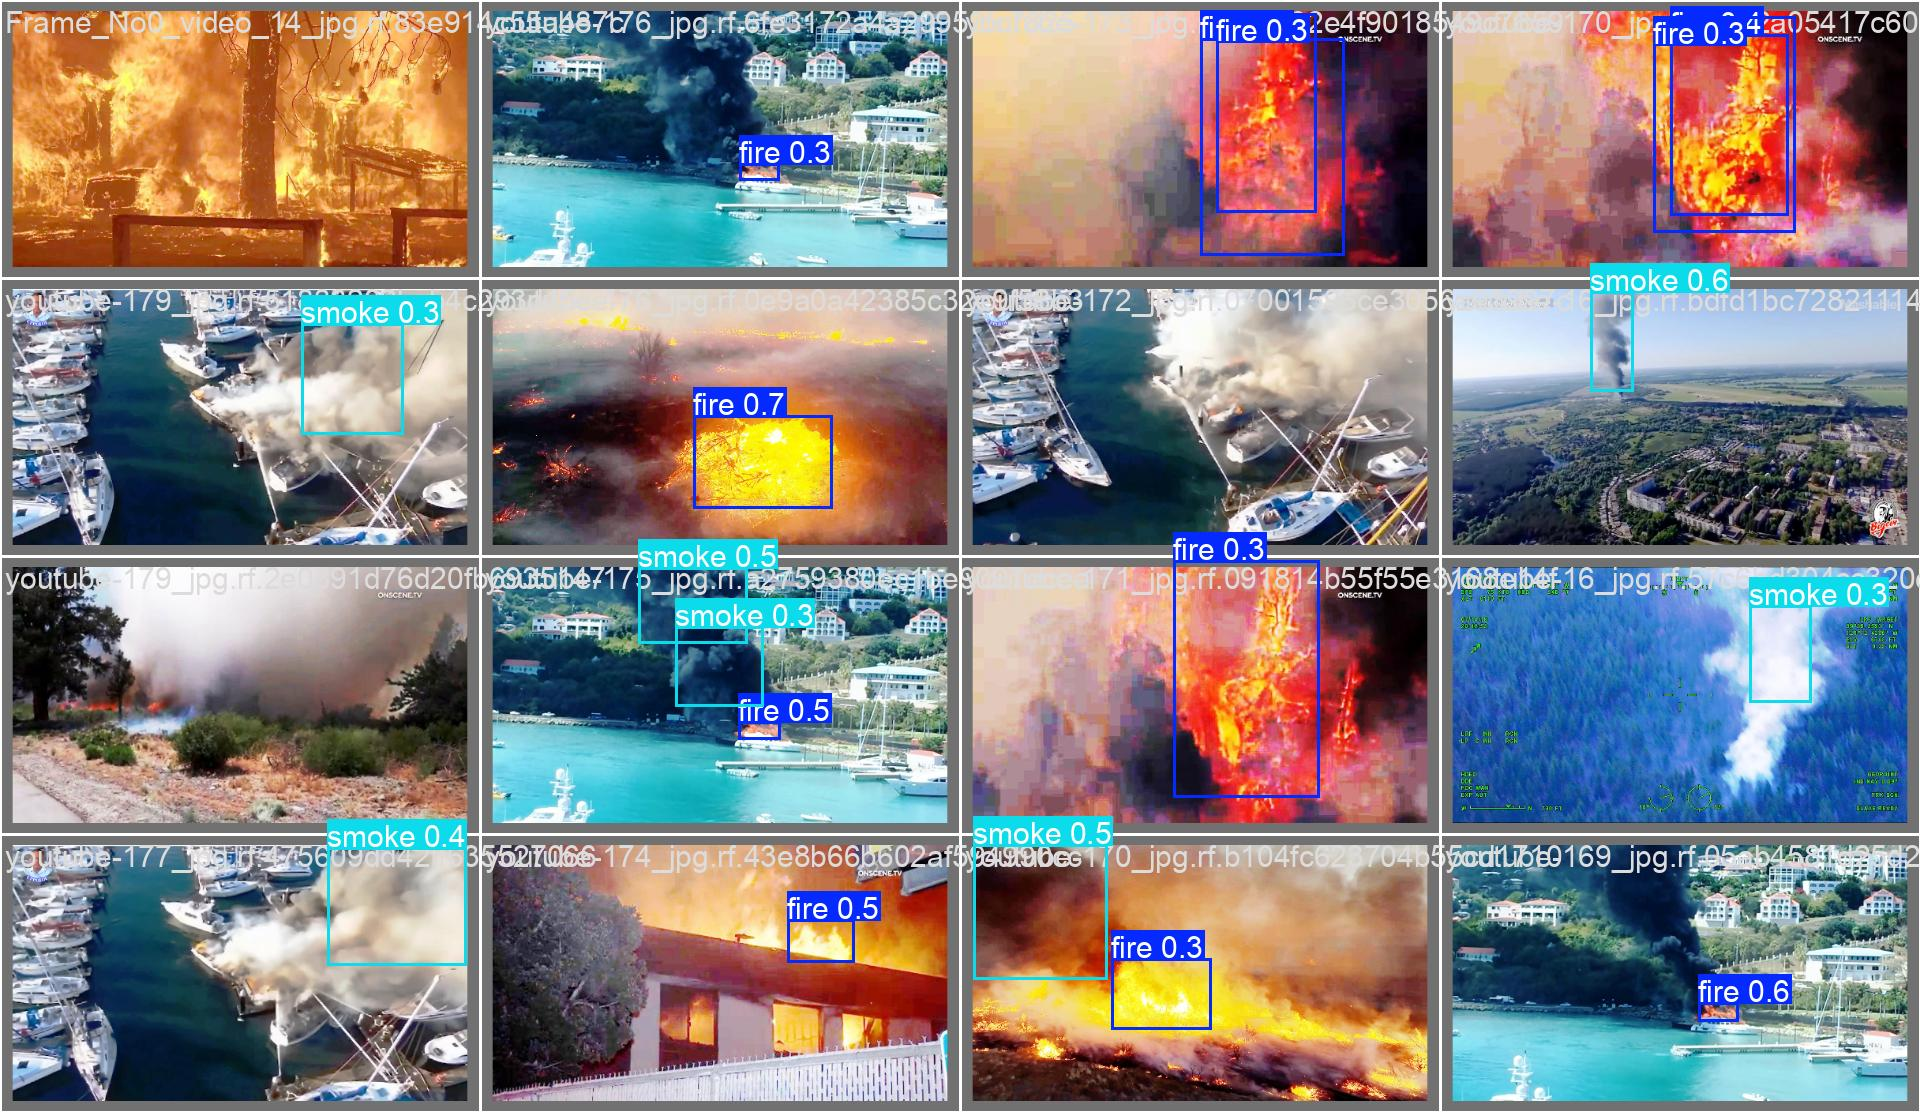

In [ ]:
for image_path in glob.globf('/content/runs/detect/train/val_batch0_pred.jpg')[:10]:
      display(Image(filename=image_path, width=400))
      print("\n")